#### Objectivo
 + Importar as bibliotecas necessárias para treinar os modelos e processar um sinal ruidoso
 + Gerar um sinal senoidal estacionário e adicionar um ruído gaussiano
 + Separar as samples e treino e teste
 + Criar e treinar o modelo na série temporal
 + Avaliar o desempenho do modelo nas samples de teste e calcular as métricas MAE/MSE/SMAPE
 + Obter amostra prevista pelo modelo e usar um mecanismo de filtro gaussiano para comparar com o sinal original
 + Avaliar a performance desse processo


In [130]:
import darts 
import torch 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import warnings 
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.nhits import NHiTSModel
from darts.models.filtering.gaussian_process_filter import GaussianProcessFilter
from darts.metrics import mae, mse, smape

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
warnings.filterwarnings('ignore')
plt.style.use('default')

%matplotlib inline

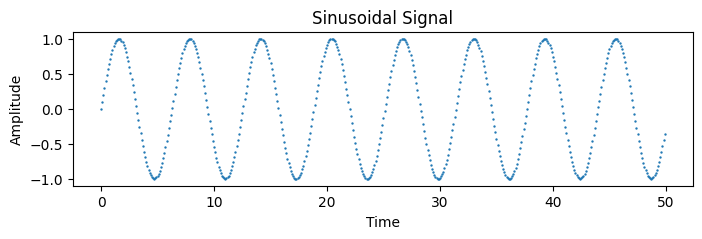

In [119]:
# gerando o sinal senoidal
time   = np.arange(0, 50, 0.1)
signal = np.sin(time)

plt.figure(figsize=(8,2))
plt.title('Sinusoidal Signal')
plt.scatter(time, signal, s=0.5)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

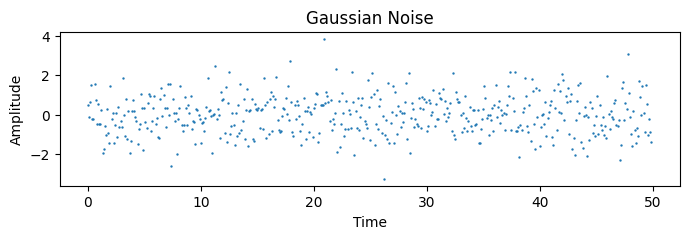

In [120]:
# Gerando ruído gaussiano
noise = np.random.normal(0, 1, size=len(time))

plt.figure(figsize=(8,2))
plt.title('Gaussian Noise')
plt.scatter(time, noise, s=0.5)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

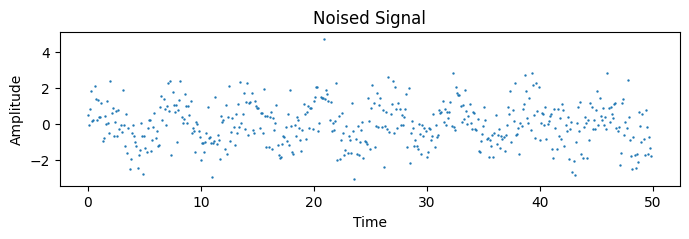

In [121]:
noised_signal = signal + noise

plt.figure(figsize=(8,2))
plt.title('Noised Signal')
plt.scatter(time, noised_signal, s=0.5)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

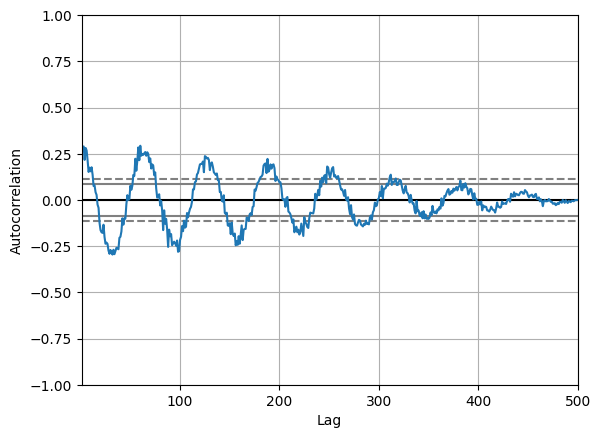

In [122]:
pd.plotting.autocorrelation_plot(pd.Series(noised_signal))

In [123]:
# data normalization
noised_signal = darts.TimeSeries.from_values(noised_signal)
scaler = Scaler().fit(noised_signal)
scaled_signal = scaler.transform(noised_signal)

In [124]:
train_size = int(0.7 * len(scaled_signal))
train_samples, test_samples = scaled_signal[0 :train_size], scaled_signal[train_size: ]

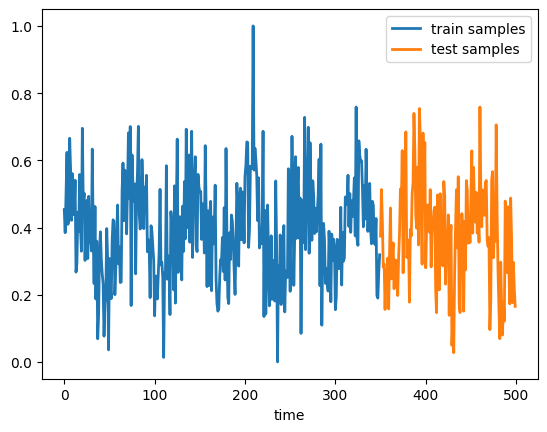

In [125]:
train_samples.plot(label='train samples')
test_samples.plot(label='test samples')
plt.show()

In [126]:
model = NHiTSModel(input_chunk_length=20,
                   output_chunk_length=10,
                   batch_size=16)

model.fit(series=train_samples, epochs=10)
pred_signal = model.predict(len(test_samples))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 830 K 
---------------------------------------------------
820 K     Trainable params
10.3 K    Non-trainable params
830 K     Total params
3.322     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 21/21 [00:00<00:00, 41.65it/s, train_loss=0.0246] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:00<00:00, 41.51it/s, train_loss=0.0246]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s]


In [127]:
mae = mae(test_samples, pred_signal)
mse = mse(test_samples, pred_signal)
smape = smape(test_samples, pred_signal)

<BarContainer object of 2 artists>

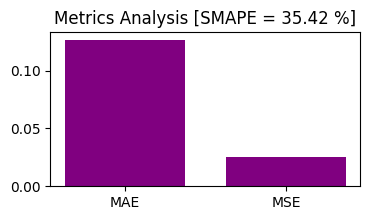

In [128]:
metrics = {'MAE'   : mae,
           'MSE'   : mse}

plt.figure(figsize = (4,2))
plt.title(f'Metrics Analysis [SMAPE = {smape:.2f} %]')
plt.bar(list(metrics.keys()), 
        list(metrics.values()),
        color='purple',
        width = .75)

Text(0.5, 0, 'Time')

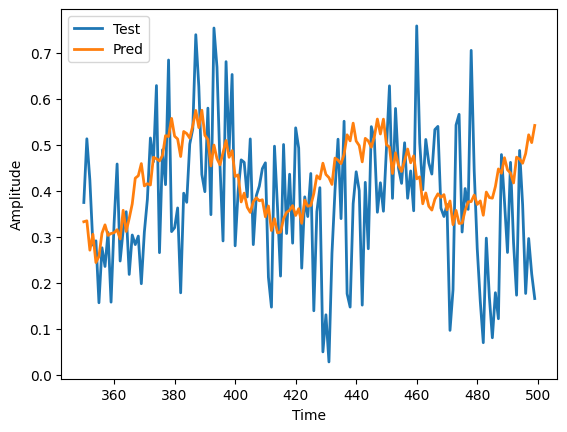

In [129]:
plt.title('Actual vs Predicted')
test_samples.plot(label='Test')
pred_signal.plot(label='Pred')
plt.ylabel('Amplitude')
plt.xlabel('Time')

In [ ]:
gaussian_filter = Gau